# Weighted K-Means

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.countries`** A 2D array with the country indicator at each latitude/longitude.


* **`utils.nx`** The number of latitudes considered.


* **`utils.ny`** The number of longitudes considered.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (100,160),
(100,170),(100,180) given as input.

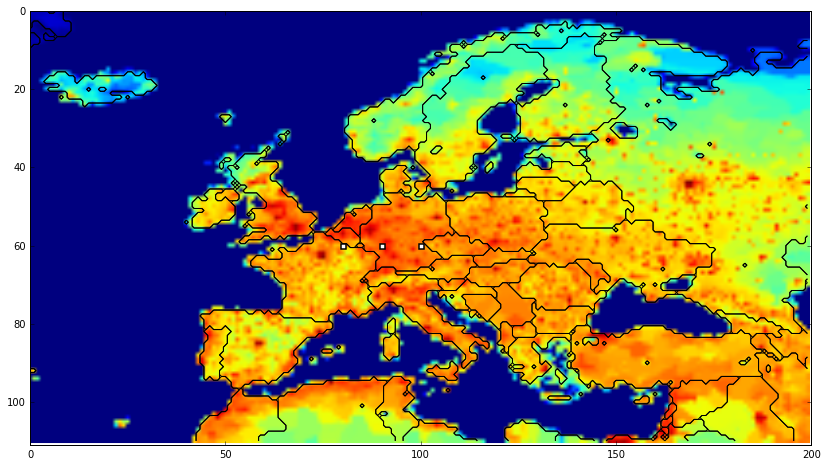

In [1]:
import utils
import numpy as np
%matplotlib inline
utils.plot([60,60,60],[80,90,100])

## Initializing Weighted K-Means (20 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. We consider the following heuristic for initialization: We assign a random score $s(x,y)$ to each geographical coordinate $(x,y)$. The score is computed as

$$
s(x,y) = \log(1+\mathrm{population}(x,y)) + N(x,y)
$$

where $N(x,y) \sim \mathrm{exp(\lambda)}$ is a noise term that follows an exponential probability density of scale parameter $\lambda$ to be determined. The centroids are chosen to be the K locations with highest score.


**Tasks:**

* **Implement the initialization procedure above.**
* **Choose an appropriate $\lambda$ and run the initialization procedure for K=100 clusters.**
* **Visualize the centroids obtained with your initialization procedure using `utils.plot`.**

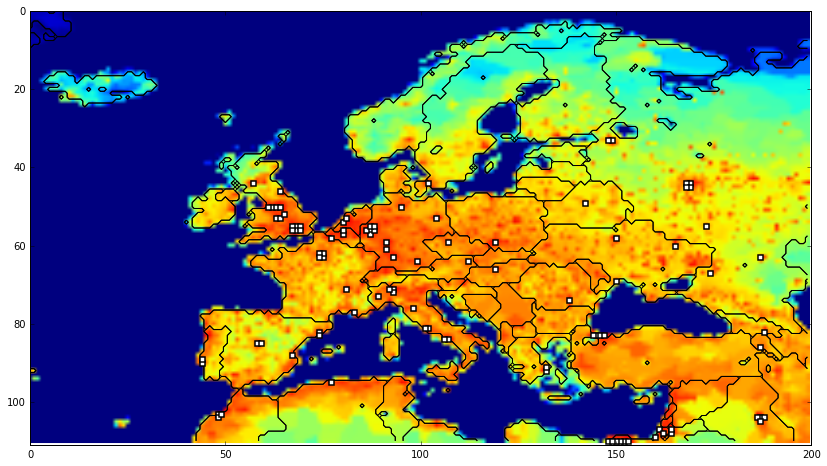

In [2]:
def km_init(k,P,lamb = -1e10):
    scores = np.log(1. + P) + np.exp(lamb)
    flat_coords = np.argsort(scores.flatten())[::-1][:k]
    coords =  np.unravel_index(flat_coords,P.shape)
    return np.array(coords).T


centroids = km_init(100,utils.population)
utils.plot(centroids[:,0],centroids[:,1])


## Implementing Weighted K-Means (40 P)

**Tasks:**


* **Implement the weighted K-Means algorithm as described in the introduction.**


* **Run the algorithm with K=100 centroids until convergence (stop if the objective does not improve by more than 0.01). Convergence should occur after less than 50 iterations. If it takes longer, something must be wrong.**


* **Print the value of the objective function at each iteration.**


* **Visualize the centroids at the end of the training procedure using the methods `utils.plot`.**

Iteration 1 with objective value 34.985019
Iteration 2 with objective value 26.563757
Iteration 3 with objective value 24.593136
Iteration 4 with objective value 23.507404
Iteration 5 with objective value 22.783955
Iteration 6 with objective value 22.202619
Iteration 7 with objective value 21.702846
Iteration 8 with objective value 21.358382
Iteration 9 with objective value 20.881539
Iteration 10 with objective value 20.552745
Iteration 11 with objective value 19.883399
Iteration 12 with objective value 19.821272
Iteration 13 with objective value 19.821475


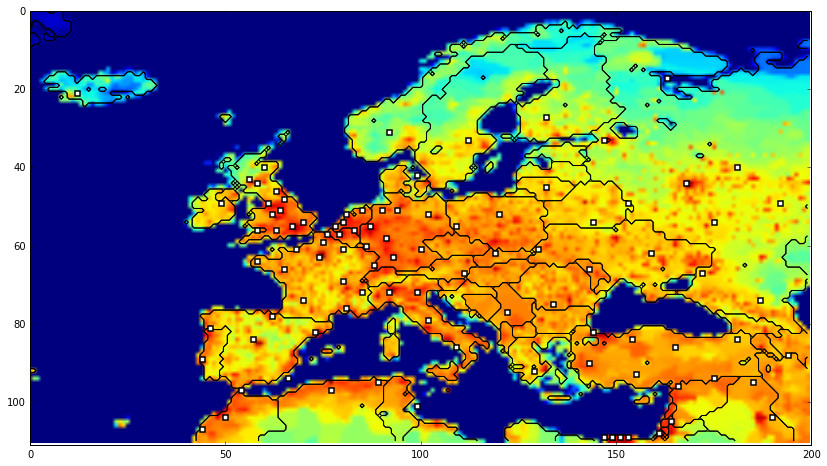

In [3]:
def weighted_kmeans(K,P):
    centroids = km_init(K,P)
    points = np.indices(P.shape).reshape((2,-1)).T
    last_J = None
    converged = False
    iter_ct = 0
    while not converged:
        
        #Expectation step
        #min_dists = np.ones(points.shape[1]) * np.sum(np.array(P.shape)**2)
        #clusters = np.zeros(points.shape[1],dtype=int) - 1
        #for k in range(K):
        #    new_dist = np.sum((points - centroids[k])**2,axis=1)
        #    dist_update = min_dists > new_dist
        #    min_dists[dist_update] = new_dist[dist_update]
        #    clusters[dist_update] = k
        
        clusters = np.argmin(((points[:,:,np.newaxis] - centroids[:,:,np.newaxis].swapaxes(0,2))**2).sum(1),axis=1)
        
        #Minimization step
        for k in range(K):
            pts = points[clusters == k]
            if pts.size == 0:
                #print "Empty Cluster!" #maybe choose a random point to be a new cluster
                #centroids[k] = points.ravel()[np.random.randint(0,np.prod(points.shape))]
                continue
            weight = P.ravel()[np.ravel_multi_index(pts.T,P.shape)][:,np.newaxis]
            centroids[k] = (pts * weight).sum(0) / weight.sum()
        
        J = (P.ravel() * ((points - centroids[clusters])**2).sum(1).T ).sum() / P.sum()
        iter_ct += 1
        print "Iteration %d with objective value %f"%(iter_ct,J)
        
        if last_J != None:
            converged = np.abs(last_J - J) < 0.01
        
        last_J = J
    
    return centroids

centroids = weighted_kmeans(100,utils.population)
utils.plot(centroids[:,0],centroids[:,1])
        
        
        

## Focus on German-Speaking Countries (15 P)

Market analysis has shown that people in German-speaking countries, more precisely, Germany (country 111), Austria(country 104), and Switzerland (country 109), are 25 times more likely to be customers than in other countries.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

## Answer
We simply multiply the population for all points within those countries by 25, therefore increasing its weigth by 25.

Iteration 1 with objective value 233.013703
Iteration 2 with objective value 113.581437
Iteration 3 with objective value 92.890282
Iteration 4 with objective value 79.768635
Iteration 5 with objective value 67.641808
Iteration 6 with objective value 57.230993
Iteration 7 with objective value 50.525078
Iteration 8 with objective value 44.619490
Iteration 9 with objective value 39.480837
Iteration 10 with objective value 37.228189
Iteration 11 with objective value 35.686000
Iteration 12 with objective value 34.607871
Iteration 13 with objective value 33.815506
Iteration 14 with objective value 33.073462
Iteration 15 with objective value 32.523649
Iteration 16 with objective value 32.036757
Iteration 17 with objective value 31.506447
Iteration 18 with objective value 31.111929
Iteration 19 with objective value 30.810350
Iteration 20 with objective value 30.660366
Iteration 21 with objective value 30.420614
Iteration 22 with objective value 29.949595
Iteration 23 with objective value 29.25

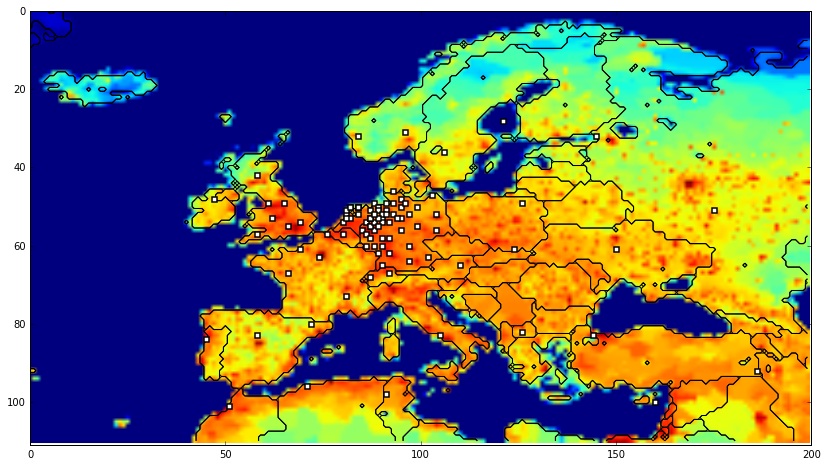

In [4]:
def apply_country_weight(P,C,label,weight):
    P = np.copy(P)
    ctry_mod = np.zeros(C.shape,dtype=bool)
    for country in label:
        ctry_mod |= C == country
    P[ctry_mod] *= weight
    
    return P

population = apply_country_weight(utils.population,utils.countries,[111,104,109],25.)
centroids = weighted_kmeans(100,population)
utils.plot(centroids[:,0],centroids[:,1])

## Shipping Restrictions (15 P)

We now suppose that deliveries across national borders are taxed heavily, and should be avoided as much as possible.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

We can apply kmeans for each country individually and assign each a number of clusters depending on the population

Iteration 1 with objective value 4.459889
Iteration 2 with objective value 4.450147
Iteration 1 with objective value 16.310794
Iteration 2 with objective value 13.091932
Iteration 3 with objective value 12.301704
Iteration 4 with objective value 12.237620
Iteration 5 with objective value 12.198837
Iteration 6 with objective value 12.165004
Iteration 7 with objective value 12.165004
Iteration 1 with objective value 46.938815
Iteration 2 with objective value 46.938815
Iteration 1 with objective value 32.340833
Iteration 2 with objective value 28.643231
Iteration 3 with objective value 25.527423
Iteration 4 with objective value 20.297388
Iteration 5 with objective value 17.938668
Iteration 6 with objective value 17.478813
Iteration 7 with objective value 17.478813
Iteration 1 with objective value 62.274488
Iteration 2 with objective value 53.359008
Iteration 3 with objective value 48.326615
Iteration 4 with objective value 47.186356
Iteration 5 with objective value 46.804512
Iteration 6 w

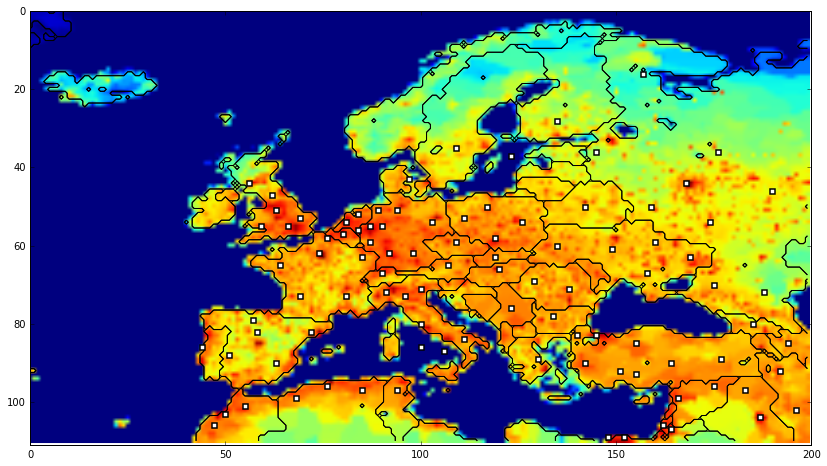

In [5]:
def country_ratio(P,C):
    norm = np.sum(P)
    ratios = dict()
    countries = np.unique(C)
    for country in countries:
        ratios[country] = float(float(P[C == country].sum()) / float(norm))
    
    return ratios

def country_pop(P,C,label):
    P = np.copy(P)
    
    P[C != label] = 0
    
    return P

def country_kmeans(K,P,C):
    ratios = country_ratio(P,C)
    ctry_clusters = []
    for country in ratios:
        ctry_k = int(round(ratios[country] * K))
        if ctry_k == 0:
            continue
        ctry_P = country_pop(P,C,country)
        ctry_clusters.append( weighted_kmeans(ctry_k,ctry_P) )
    clusters = np.concatenate(ctry_clusters)
    return clusters

centroids = country_kmeans(100,utils.population,utils.countries)
utils.plot(centroids[:,0],centroids[:,1])

## Discussion (10 P)

Explain in approximately two paragraphs what are the advantages and limitation of the K-Means model to the problem of optimal resource allocation. Example of points that your answer could cover are:

* Flexibility of the method with respect to various real-world constraints.
* Validity of the squared Euclidean distance as a measure of shipping cost.